In [1]:
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/aleksander/anaconda3/envs/bigaischool/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
!pwd

/home/aleksander/PycharmProjects/bigaischool/DEEP LEARNING/TIME SERIES


In [7]:
data = pd.read_csv("./Data/EURUSD5.csv")

In [8]:
data.head()

2019.03.29  10:15  1.12330  1.12358  1.12221  1.12250  451
0  2019.03.29  10:20  1.12250  1.12283  1.12250  1.12263  332
1  2019.03.29  10:25  1.12263  1.12274  1.12218  1.12235  412
2  2019.03.29  10:30  1.12238  1.12315  1.12232  1.12305  417
3  2019.03.29  10:35  1.12305  1.12308  1.12264  1.12279  308
4  2019.03.29  10:40  1.12278  1.12279  1.12237  1.12248  416

In [4]:
to_remove = ["time","Diff_CO","Growing"]

In [5]:
data = data[data.columns.difference(to_remove)]

In [6]:
data.head()

C        H        L        O  volume
0  1.14476  1.14484  1.14476  1.14482    21.0
1  1.14470  1.14479  1.14465  1.14479    11.0
2  1.14484  1.14484  1.14466  1.14468    19.0
3  1.14496  1.14496  1.14476  1.14482    13.0
4  1.14496  1.14496  1.14482  1.14494    16.0

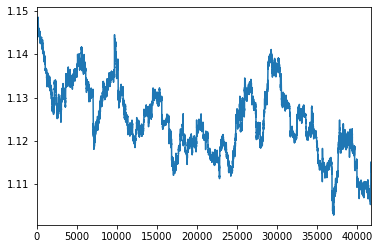

In [7]:
data["O"].plot()

In [8]:
data.shape

(41732, 5)

In [9]:
batch_size = 128
timesteps = 16
n_timeseries = data.shape[1]-1
train_length = 36000
val_length = 2866
test_length = 2866
target = "O"

In [10]:
len(data)

41732

In [11]:
n_timeseries

4

In [12]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
Y = np.zeros((len(data), timesteps, 1))

In [13]:
X.shape

(41732, 16, 4)

In [14]:
Y.shape

(41732, 16, 1)

In [15]:
X[0]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [16]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [17]:
X[0]

array([[1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482],
       [1.14476, 1.14484, 1.14476, 1.14482]])

In [18]:
for j in range(timesteps):
    Y[:, j, 0] = data["O"].shift(timesteps - j - 1).fillna(method="bfill")

In [19]:
Y[0]

array([[1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482],
       [1.14482]])

In [20]:
prediction_horizon = 1
target = data["O"].shift(-prediction_horizon).fillna(method="ffill").values

In [21]:
target.shape

(41732,)

In [22]:
X = X[timesteps:]
Y = Y[timesteps:]
target = target[timesteps:]

In [23]:
target

array([1.1446 , 1.14444, 1.14425, ..., 1.11465, 1.11452, 1.11452])

In [24]:
X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]
Y_his_train = Y[:train_length]
Y_his_val = Y[train_length:train_length+val_length]
Y_his_test = Y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [25]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
Y_his_train_max = Y_his_train.max(axis=0)
Y_his_train_min = Y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [26]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

Y_his_train = (Y_his_train - Y_his_train_min) / (Y_his_train_max - Y_his_train_min)
Y_his_val = (Y_his_val - Y_his_train_min) / (Y_his_train_max - Y_his_train_min)
Y_his_test = (Y_his_test - Y_his_train_min) / (Y_his_train_max - Y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [27]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).cuda()
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [28]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [29]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cuda()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cuda()
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [30]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
Y_his_train_t = torch.Tensor(Y_his_train)
Y_his_val_t = torch.Tensor(Y_his_val)
Y_his_test_t = torch.Tensor(Y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [31]:
model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [33]:
from torch.utils.data import TensorDataset, DataLoader
data_train_loader = DataLoader(TensorDataset(X_train_t, Y_his_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, Y_his_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, Y_his_test_t, target_test_t), shuffle=False, batch_size=128)

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Saving...
Iter:  0 train:  0.10376198163514708 val:  0.03667576262317359
mse:  1.9443855e-06 mae:  0.0009492392


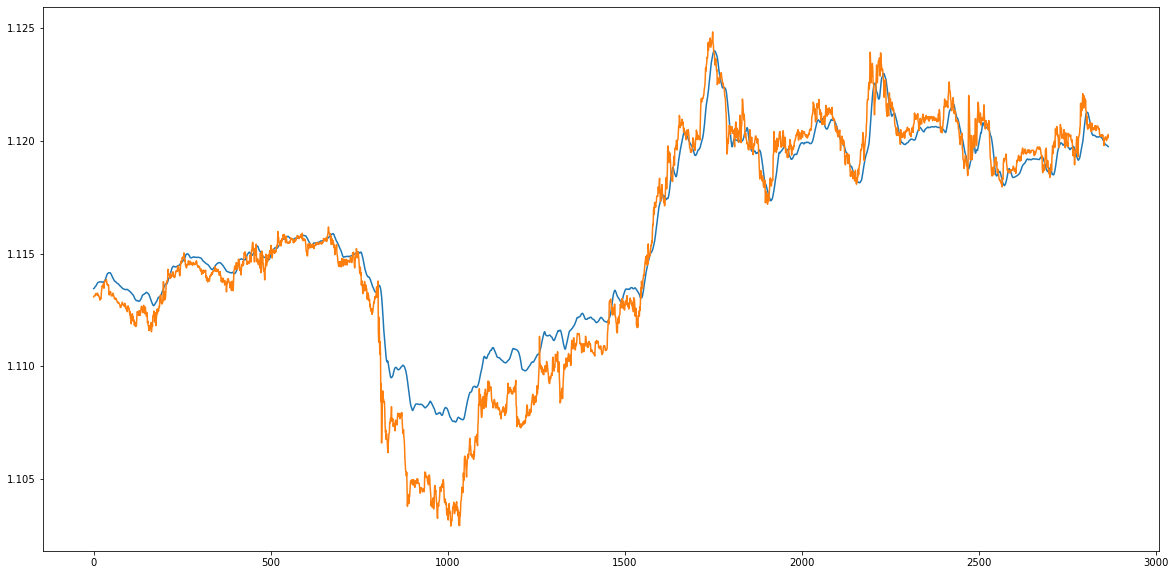

Saving...
Iter:  1 train:  0.016547156227514605 val:  0.02769811593603453
Saving...
Iter:  2 train:  0.015349598551646849 val:  0.022910546886111466
Saving...
Iter:  3 train:  0.01324302411770442 val:  0.01788830968813441
Saving...
Iter:  4 train:  0.008790715967350244 val:  0.015970278627013126
Saving...
Iter:  5 train:  0.006382870587526149 val:  0.0142301904390921
Saving...
Iter:  6 train:  0.005334658603588095 val:  0.01413562814311165
Saving...
Iter:  7 train:  0.004901122933636895 val:  0.012861616545584887
Saving...
Iter:  8 train:  0.004933716307301102 val:  0.012776231358984692
Iter:  9 train:  0.004761873741111837 val:  0.013204031187914333
Iter:  10 train:  0.004997584744988955 val:  0.013415919602527178
mse:  2.6017412e-07 mae:  0.000277772


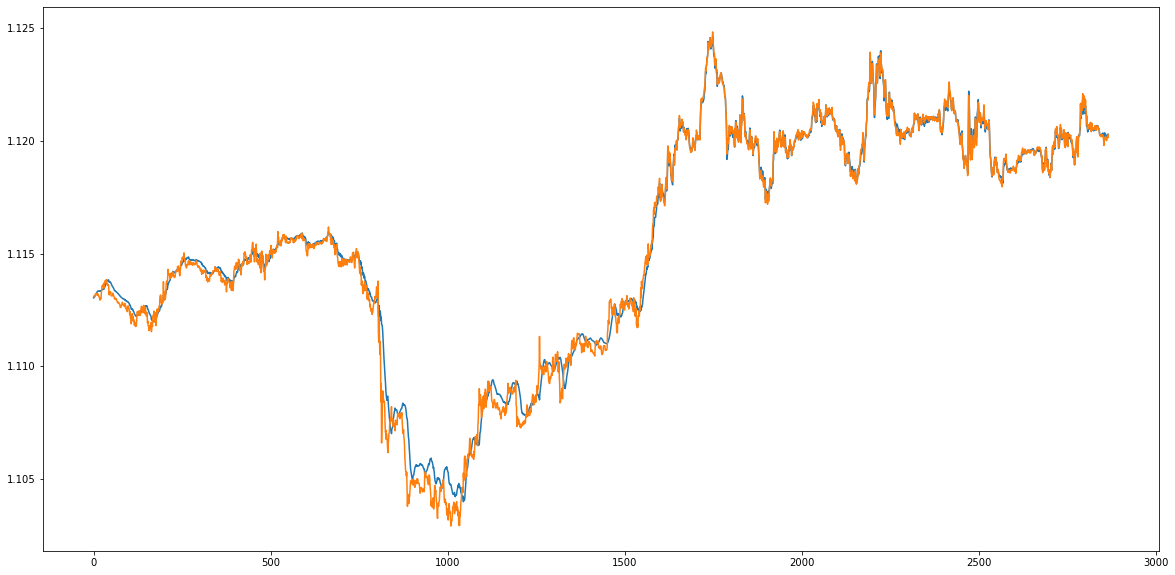

Saving...
Iter:  11 train:  0.004558618371400367 val:  0.01242492068796775
Iter:  12 train:  0.004719847715991796 val:  0.012432915287475414
Iter:  13 train:  0.004485476637438552 val:  0.01293492200844351
Iter:  14 train:  0.004554581485732873 val:  0.013042921902490373
Iter:  15 train:  0.004322308245532978 val:  0.012466115722893596
Iter:  16 train:  0.004029115142700872 val:  0.012505927333617092
Iter:  17 train:  0.004305846155311041 val:  0.01319935909260652
Iter:  18 train:  0.00462428840703168 val:  0.012461931868446983
Iter:  19 train:  0.004676323371094493 val:  0.012659988436575988
Iter:  20 train:  0.0038063921807642087 val:  0.0124379099271756
mse:  2.2362481e-07 mae:  0.00024320812


Iter:  21 train:  0.0036829156522554542 val:  0.012481256046451903
Iter:  22 train:  0.003649351829638427 val:  0.012436702146999538
Iter:  23 train:  0.003797913400580035 val:  0.012447668931576603
Iter:  24 train:  0.003738115755469586 val:  0.017255030965333935
Saving...
Iter:  25 train:  0.003885908635601238 val:  0.012407790250123072
Iter:  26 train:  0.003993702784483364 val:  0.012409389022071464
Saving...
Iter:  27 train:  0.003711385668059623 val:  0.012294043695256556
Iter:  28 train:  0.003415752941809085 val:  0.012768489768524629
Iter:  29 train:  0.003337398455287117 val:  0.012803884725075723
Iter:  30 train:  0.0037620039368978743 val:  0.012630398571563946
mse:  2.3060059e-07 mae:  0.00023141735


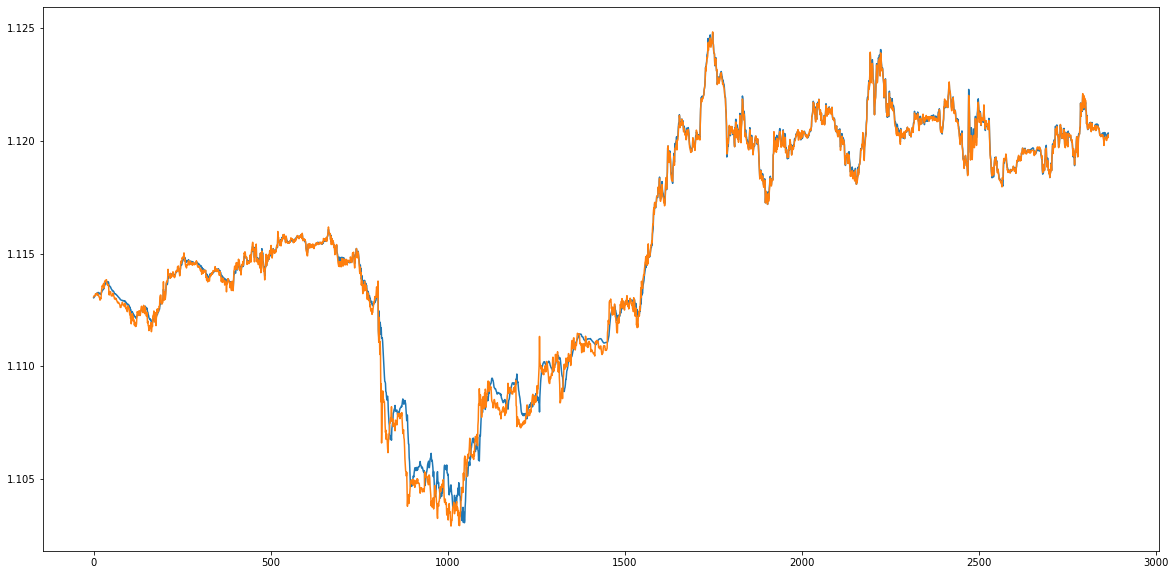

Saving...
Iter:  31 train:  0.003223605367386464 val:  0.01221663260832675
Iter:  32 train:  0.0034109335473455895 val:  0.012379523396958301
Iter:  33 train:  0.003170619936927054 val:  0.012456470586584169
Iter:  34 train:  0.0034551179731960317 val:  0.01313315606791863
Iter:  35 train:  0.0033656553907211277 val:  0.012232244239209671
Iter:  36 train:  0.003088483934025965 val:  0.013434464173341383
Iter:  37 train:  0.0032867265369502787 val:  0.01340278769080673
Iter:  38 train:  0.003302048067382777 val:  0.013472501921512834
Iter:  39 train:  0.0030807354508817475 val:  0.012935123161818074
Iter:  40 train:  0.0028590747488760984 val:  0.013037383989933543
mse:  2.4569974e-07 mae:  0.00022601054


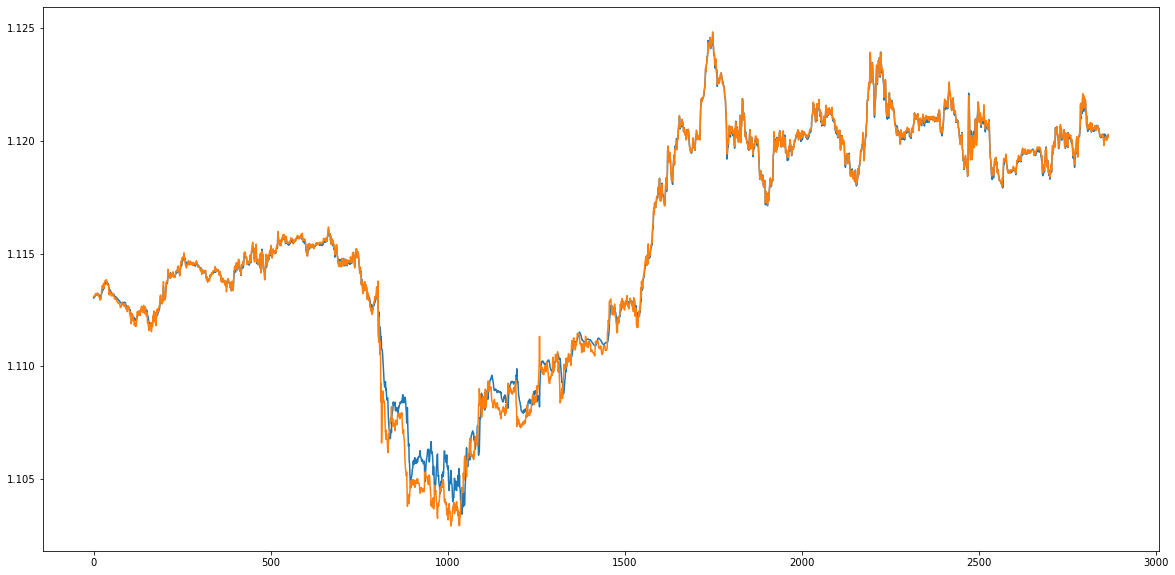

Iter:  41 train:  0.002820002586888914 val:  0.013338903253567121
Iter:  42 train:  0.0030070046226178975 val:  0.013421859749764087
Iter:  43 train:  0.0031088452531094976 val:  0.012428684001023907
Iter:  44 train:  0.002889262107067034 val:  0.013606952306013678
Iter:  45 train:  0.0031497198300091626 val:  0.013071264652985342
Saving...
Iter:  46 train:  0.0026342540989561392 val:  0.011956318653858973
Iter:  47 train:  0.0027251574173779367 val:  0.011997133471102699
Iter:  48 train:  0.0030031033390232674 val:  0.01252254136343283
Iter:  49 train:  0.0028741164477396487 val:  0.01360741927398889
Iter:  50 train:  0.002897864347080897 val:  0.01333230738737605
mse:  2.5694143e-07 mae:  0.00023152832


Saving...
Iter:  51 train:  0.002920094877519977 val:  0.01162860238915555
Saving...
Iter:  52 train:  0.0028656656811438717 val:  0.011516713176558748
Iter:  53 train:  0.002732723543250883 val:  0.011647567764114597
Saving...
Iter:  54 train:  0.0026665404514010357 val:  0.011323592121405036
Iter:  55 train:  0.0027286413474988396 val:  0.012008831417619806
Saving...
Iter:  56 train:  0.002996809346970166 val:  0.011145197566776753
Saving...
Iter:  57 train:  0.0026082905653166226 val:  0.01108059762986592
Iter:  58 train:  0.0027075716172122767 val:  0.01137963433263381
Saving...
Iter:  59 train:  0.0027996626702213065 val:  0.010887537514171201
Saving...
Iter:  60 train:  0.0024603494091329932 val:  0.010824802018499103
mse:  1.6938104e-07 mae:  0.00018021392


Iter:  61 train:  0.0025756641531148334 val:  0.012277365120962837
Saving...
Iter:  62 train:  0.0025003944061018574 val:  0.010742000328764646
Saving...
Iter:  63 train:  0.002705317561329894 val:  0.010617660841548722
Iter:  64 train:  0.002303581695921863 val:  0.010662658170433674
Iter:  65 train:  0.002417186933650067 val:  0.010778200010609102
Iter:  66 train:  0.0023834173597712684 val:  0.01066646652256394
Iter:  67 train:  0.0024488580897844355 val:  0.011514019366940716
Saving...
Iter:  68 train:  0.002367040600591341 val:  0.00998753469456665
Saving...
Iter:  69 train:  0.002640770523918628 val:  0.009661854624420319
Saving...
Iter:  70 train:  0.0023100813679217116 val:  0.009600012683956499
mse:  1.3321959e-07 mae:  0.0001565534


Iter:  71 train:  0.0023189985147638106 val:  0.009756336823504312
Iter:  72 train:  0.002255549884945507 val:  0.009690882210503566
Saving...
Iter:  73 train:  0.0023379408121531626 val:  0.009008409989214743
Iter:  74 train:  0.0021483101428489896 val:  0.009284024841762597
Saving...
Iter:  75 train:  0.00221227949029609 val:  0.008944032833796803
Saving...
Iter:  76 train:  0.002211476352076241 val:  0.008877569588780115
Saving...
Iter:  77 train:  0.0022383916737311596 val:  0.008784023628843797
Iter:  78 train:  0.002146928210636093 val:  0.00890957021530909


In [ ]:
epochs = 150
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "darnn_FX.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [1]:
data_val_loader

NameError: name 'data_val_loader' is not defined

In [ ]:
pred_michal= []

for batch_x, batch_y_h, batch_y in data_val_loader:
    
if(i % 10 == 0):
    preds = preds*(target_train_max - target_train_min) + target_train_min
    true = true*(target_train_max - target_train_min) + target_train_min
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    print("mse: ", mse, "mae: ", mae)
    plt.figure(figsize=(20, 10))
    plt.plot(preds)
    plt.plot(true)
    plt.show()

In [ ]:
model.load_state_dict(torch.load("darnn_FX.pt"))

In [ ]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [ ]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [ ]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()